# World Happiness Rankings Machine Learning Project

by Yassine Turki, Tudor Cardas, and Paula González Álvarez

First draft: In this project we will take the IMF's World Development Indicators data that we deem the most relevant to determine happiness and download it for multiple years and for the countries that are included in the World Happiness Reports. Then, we will clean our data and run a regression using the real Happiness Report Rankings to find a the weights we should include for each indicator. Then, we will apply that formula to our data and check how the ratings we find compare to those in the World Happiness Reports and check it against different years.

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.impute import KNNImputer 
from keras.layers import Input, Dense, Lambda
from keras.models import Model  
from keras import backend as K


In [130]:
data = pd.read_excel(r"ML_DATA_original.xlsx")

In [131]:
data

,Sum of Value,Column Labels,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39
0,Row Labels,Access to clean fuels and technologies for coo...,"Compulsory education, duration (years)",Current health expenditure (% of GDP),"Death rate, crude (per 1,000 people)",Electric power consumption (kWh per capita),"Employment to population ratio, 15+, total (%)...","Fertility rate, total (births per woman)",Fixed telephone subscriptions (per 100 people),Forest area (% of land area),...,Ratio of female to male labor force participat...,Refugee population by country or territory of ...,"School enrollment, secondary (% gross)","Suicide mortality rate (per 100,000 population)","Survival to age 65, female (% of cohort)","Survival to age 65, male (% of cohort)",Total greenhouse gas emissions (kt of CO2 equi...,"Unemployment, total (% of total labor force) (...","Wage and salaried workers, total (% of total e...",Grand Total
1,2000,8391.46,1076,775.777262,1349.057,453674.293419,4392.189985,449.339,2758.315553,4145.151445,...,6072.9659,8291187,7558.451849,1708.1,10476.178627,9021.033037,31725940.17905,824.859996,7955.279975,2692451315.520399
2,Afghanistan,6.2,6,0,12.096,0,0,7.534,0.148391,1.852782,...,0,3587327,0,4.9,53.334998,46.116872,13890.000343,0,6.74,8196484.067662
3,Albania,38.2,8,7.23337,5.798,1449.647413,0,2.231,4.79843,28.076642,...,65.339229,6801,71.078079,4.9,88.478474,80.135436,8140.000343,16.799999,35.889999,1334635.142155
4,Algeria,97.1,10,3.489033,5.037,689.236758,0,2.566,5.72331,0.662961,...,14.164004,8015,65.116982,4.5,78.3963,72.854115,162619.995117,29.77,61.720001,9098773.82504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3187,Vietnam,0,10,0,0,0,71.160004,0,3.203604,0,...,87.660661,317737,0,0,0,0,0,2.38,0,55353256.913871
3188,Yemen,0,9,0,0,0,0,0,0,0,...,0,37611,0,0,0,0,0,0,0,7572679.6
3189,Zambia,0,7,0,0,0,57,0,0.338482,0,...,81.61543,255,0,0,0,0,0,5.2,0,6700657.838878
3190,Zimbabwe,0,7,0,0,0,0,0,1.521997,0,...,0,8115,0,0,0,0,0,0,0,6209259.385732


In [132]:
#Renaming the columns 

d={col:0 for col in data.columns}
i=0
for k in d.keys():
    d[k]=data.iloc[0].to_list()[i]
    i+=1
data=data.rename(columns=d)[1:]


In [133]:
#We only have the scores from 2015 to 2021, so we drop the rest of the years 

index_2015= data.index[data['Row Labels'] == 2015].tolist()[0]
data=data.iloc[index_2015:-1,:]

In [134]:
#Handling the index error

data=data.reset_index()
data=data.drop(columns=["index"])

In [135]:
#Renaming and dropping grand total column

data=data.rename(columns={"Row Labels":"Countries"})
data=data.drop(columns=["Grand Total"])

In [138]:
#Convert into float
cols_to_convert = data.columns.difference(['Countries'])
data[cols_to_convert] = data[cols_to_convert].astype(float)

In [139]:
data.head(148)

,Countries,Access to clean fuels and technologies for cooking (% of population),"Compulsory education, duration (years)",Current health expenditure (% of GDP),"Death rate, crude (per 1,000 people)",Electric power consumption (kWh per capita),"Employment to population ratio, 15+, total (%) (national estimate)","Fertility rate, total (births per woman)",Fixed telephone subscriptions (per 100 people),Forest area (% of land area),...,Prevalence of undernourishment (% of population),Ratio of female to male labor force participation rate (%) (national estimate),Refugee population by country or territory of origin,"School enrollment, secondary (% gross)","Suicide mortality rate (per 100,000 population)","Survival to age 65, female (% of cohort)","Survival to age 65, male (% of cohort)",Total greenhouse gas emissions (kt of CO2 equivalent),"Unemployment, total (% of total labor force) (national estimate)","Wage and salaried workers, total (% of total employment) (modeled ILO estimate)"
0,Afghanistan,27.40,9.0,10.105348,7.331000,0.0,0.000000,5.4050,0.325892,1.852782,...,21.5,0.000000,2666294.0,51.669949,4.0,65.498060,56.993402,2.709000e+04,0.000000,15.790000
1,Albania,76.20,9.0,4.896312,7.947000,0.0,45.959999,1.6130,7.865380,28.802464,...,4.9,73.328137,10404.0,97.388481,4.8,91.512091,84.678267,9.220000e+03,17.190001,41.189999
2,Algeria,99.50,10.0,6.978489,4.437000,0.0,37.029999,3.0410,8.263357,0.821248,...,2.8,24.390242,3470.0,0.000000,2.7,86.476312,82.114127,2.631400e+05,11.210000,68.650002
3,Argentina,99.70,14.0,10.229339,7.543000,0.0,0.000000,2.3010,23.286658,10.632187,...,2.5,0.000000,186.0,106.946472,8.3,87.294176,77.188329,3.700000e+05,0.000000,75.959999
4,Armenia,97.80,12.0,10.117634,9.607000,0.0,50.919998,1.6020,19.153997,11.574289,...,2.8,74.851452,11211.0,86.005890,6.2,87.990910,70.401364,9.160000e+03,18.260000,57.200001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,Zimbabwe,29.50,7.0,7.452066,8.774000,0.0,0.000000,3.8490,2.357495,45.689363,...,0.0,0.000000,21332.0,0.000000,18.0,53.853432,44.734556,3.070000e+04,0.000000,33.369999
144,2016,9573.35,1381.0,945.001288,1135.575365,956.0,5661.980015,383.7475,2438.247798,4142.727877,...,1152.9,7119.649951,6577782.0,9348.891390,1419.7,11595.655691,10213.791748,4.301186e+07,818.570002,8630.989997
145,Afghanistan,28.60,9.0,11.818562,7.077000,0.0,0.000000,5.2620,0.329690,1.852782,...,22.2,0.000000,2501447.0,51.655941,4.0,66.349797,57.685135,2.689000e+04,0.000000,16.500000
146,Albania,77.80,9.0,4.916017,8.035000,0.0,48.480000,1.5510,8.630148,28.802190,...,4.7,76.661010,11060.0,95.714996,4.7,91.693973,85.052413,9.090000e+03,15.420000,41.400002


In [140]:
#Loading data from happiness (to have our "Y") + extracting only the column of interest, i.e Score

h2015=pd.read_csv("2015.csv").sort_values(by=['Country'])
h2015=h2015[["Happiness Score","Country"]].reset_index().drop(columns=["index"])
h2016=pd.read_csv("2016.csv").sort_values(by=['Country'])
h2016=h2016[["Happiness Score","Country"]].reset_index().drop(columns=["index"])
h2017=pd.read_csv("2017.csv").sort_values(by=['Country'])
h2017=h2017[["Happiness.Score","Country"]].reset_index().drop(columns=["index"])
h2017.at[55,"Country"]="Hong Kong"
h2018=pd.read_csv("2018.csv").sort_values(by=['Country or region'])
h2018=h2018[["Score","Country or region"]].reset_index().drop(columns=["index"])
h2019=pd.read_csv("2019.csv").sort_values(by=['Country or region'])
h2019=h2019[["Score","Country or region"]].reset_index().drop(columns=["index"])
h2020=pd.read_csv("2020.csv").sort_values(by=['Country name'])
h2020=h2020[["Ladder score","Country name"]].reset_index().drop(columns=["index"])
h2021=pd.read_csv("2021.csv").sort_values(by=['Country name'])
h2021=h2021[["Ladder score","Country name"]].reset_index().drop(columns=["index"])
# h2022=pd.read_csv("2022.csv").sort_values(by=['Country'])["Happiness score"]

years=[h2015,h2016,h2017,h2018,h2019,h2020,h2021]


In [141]:
data.head(147)

,Countries,Access to clean fuels and technologies for cooking (% of population),"Compulsory education, duration (years)",Current health expenditure (% of GDP),"Death rate, crude (per 1,000 people)",Electric power consumption (kWh per capita),"Employment to population ratio, 15+, total (%) (national estimate)","Fertility rate, total (births per woman)",Fixed telephone subscriptions (per 100 people),Forest area (% of land area),...,Prevalence of undernourishment (% of population),Ratio of female to male labor force participation rate (%) (national estimate),Refugee population by country or territory of origin,"School enrollment, secondary (% gross)","Suicide mortality rate (per 100,000 population)","Survival to age 65, female (% of cohort)","Survival to age 65, male (% of cohort)",Total greenhouse gas emissions (kt of CO2 equivalent),"Unemployment, total (% of total labor force) (national estimate)","Wage and salaried workers, total (% of total employment) (modeled ILO estimate)"
0,Afghanistan,27.40,9.0,10.105348,7.331000,0.0,0.000000,5.4050,0.325892,1.852782,...,21.5,0.000000,2666294.0,51.669949,4.0,65.498060,56.993402,2.709000e+04,0.000000,15.790000
1,Albania,76.20,9.0,4.896312,7.947000,0.0,45.959999,1.6130,7.865380,28.802464,...,4.9,73.328137,10404.0,97.388481,4.8,91.512091,84.678267,9.220000e+03,17.190001,41.189999
2,Algeria,99.50,10.0,6.978489,4.437000,0.0,37.029999,3.0410,8.263357,0.821248,...,2.8,24.390242,3470.0,0.000000,2.7,86.476312,82.114127,2.631400e+05,11.210000,68.650002
3,Argentina,99.70,14.0,10.229339,7.543000,0.0,0.000000,2.3010,23.286658,10.632187,...,2.5,0.000000,186.0,106.946472,8.3,87.294176,77.188329,3.700000e+05,0.000000,75.959999
4,Armenia,97.80,12.0,10.117634,9.607000,0.0,50.919998,1.6020,19.153997,11.574289,...,2.8,74.851452,11211.0,86.005890,6.2,87.990910,70.401364,9.160000e+03,18.260000,57.200001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,Zambia,14.00,7.0,4.435102,7.196000,0.0,0.000000,4.7930,0.714939,61.549254,...,0.0,0.000000,334.0,0.000000,8.7,61.087586,50.871620,3.631000e+04,0.000000,22.900000
143,Zimbabwe,29.50,7.0,7.452066,8.774000,0.0,0.000000,3.8490,2.357495,45.689363,...,0.0,0.000000,21332.0,0.000000,18.0,53.853432,44.734556,3.070000e+04,0.000000,33.369999
144,2016,9573.35,1381.0,945.001288,1135.575365,956.0,5661.980015,383.7475,2438.247798,4142.727877,...,1152.9,7119.649951,6577782.0,9348.891390,1419.7,11595.655691,10213.791748,4.301186e+07,818.570002,8630.989997
145,Afghanistan,28.60,9.0,11.818562,7.077000,0.0,0.000000,5.2620,0.329690,1.852782,...,22.2,0.000000,2501447.0,51.655941,4.0,66.349797,57.685135,2.689000e+04,0.000000,16.500000


In [142]:
data["Score"]=np.zeros(len(data))
# Adding the Score column for our data:
end_of_countries=data.index[data['Countries'] == "2016"][0]
countries_in_dataframe=data.iloc[:end_of_countries,:1]
listof_countries_in_data=countries_in_dataframe["Countries"].to_list()
for i, y in enumerate(years):
    for j in range(y.shape[0]):
        if y.iloc[j][1] in listof_countries_in_data:
            data.at[data.loc[data["Countries"] == y.iloc[j][1]].index[i], 'Score'] =  y.iloc[j][0]

In [143]:
data

,Countries,Access to clean fuels and technologies for cooking (% of population),"Compulsory education, duration (years)",Current health expenditure (% of GDP),"Death rate, crude (per 1,000 people)",Electric power consumption (kWh per capita),"Employment to population ratio, 15+, total (%) (national estimate)","Fertility rate, total (births per woman)",Fixed telephone subscriptions (per 100 people),Forest area (% of land area),...,Ratio of female to male labor force participation rate (%) (national estimate),Refugee population by country or territory of origin,"School enrollment, secondary (% gross)","Suicide mortality rate (per 100,000 population)","Survival to age 65, female (% of cohort)","Survival to age 65, male (% of cohort)",Total greenhouse gas emissions (kt of CO2 equivalent),"Unemployment, total (% of total labor force) (national estimate)","Wage and salaried workers, total (% of total employment) (modeled ILO estimate)",Score
0,Afghanistan,27.4,9.0,10.105348,7.331,0.0,0.000000,5.405,0.325892,1.852782,...,0.000000,2666294.0,51.669949,4.0,65.498060,56.993402,27090.000153,0.000000,15.790000,3.575
1,Albania,76.2,9.0,4.896312,7.947,0.0,45.959999,1.613,7.865380,28.802464,...,73.328137,10404.0,97.388481,4.8,91.512091,84.678267,9220.000267,17.190001,41.189999,4.959
2,Algeria,99.5,10.0,6.978489,4.437,0.0,37.029999,3.041,8.263357,0.821248,...,24.390242,3470.0,0.000000,2.7,86.476312,82.114127,263140.014648,11.210000,68.650002,5.605
3,Argentina,99.7,14.0,10.229339,7.543,0.0,0.000000,2.301,23.286658,10.632187,...,0.000000,186.0,106.946472,8.3,87.294176,77.188329,370000.000000,0.000000,75.959999,6.574
4,Armenia,97.8,12.0,10.117634,9.607,0.0,50.919998,1.602,19.153997,11.574289,...,74.851452,11211.0,86.005890,6.2,87.990910,70.401364,9159.999847,18.260000,57.200001,4.350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,Venezuela,0.0,17.0,0.000000,0.000,0.0,0.000000,0.000,12.025153,0.000000,...,0.000000,199202.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,4.892
1010,Vietnam,0.0,10.0,0.000000,0.000,0.0,71.160004,0.000,3.203604,0.000000,...,87.660661,317737.0,0.000000,0.0,0.000000,0.000000,0.000000,2.380000,0.000000,5.411
1011,Yemen,0.0,9.0,0.000000,0.000,0.0,0.000000,0.000,0.000000,0.000000,...,0.000000,37611.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.658
1012,Zambia,0.0,7.0,0.000000,0.000,0.0,57.000000,0.000,0.338482,0.000000,...,81.615430,255.0,0.000000,0.0,0.000000,0.000000,0.000000,5.200000,0.000000,4.073


In [144]:
#Removing the year rows in our original data:
listofyears=[i for i in range(2016,2022,1)]
k=0
l=[]
for i in range(data.shape[0]):
    if data.iloc[i][0] == listofyears[k] or data.iloc[i][0]==str(listofyears[k]):
        l.append(i)
data=data.drop(l)

In [145]:
#We create a dataframe that show the missing values for each year
s=[]
for i in range(7):
    s.append((data.iloc[145*i:145*(i+1)]==0).sum())
zeros_per_column = pd.concat([s[0],s[1],s[2],s[3],s[4],s[5],s[6]],axis=1)
zeros_per_column.columns = list(range(2015,2022))
zeros_per_column['sum'] = zeros_per_column.sum(axis=1)
zeros_per_column = zeros_per_column.sort_values(by='sum', ascending=False)

zeros_per_column.head(40)


,2015,2016,2017,2018,2019,2020,2021,sum
Electric power consumption (kWh per capita),144,143,143,143,144,145,143,1005
"Literacy rate, adult total (% of people ages 15 and above)",109,114,117,84,118,119,85,746
Human capital index (HCI) (scale 0-1),145,143,8,10,143,8,143,600
Lifetime risk of maternal death (%),1,1,3,145,145,145,143,583
People practicing open defecation (% of population),53,54,59,63,68,72,143,512
"Intentional homicides (per 100,000 people)",46,49,50,60,57,70,143,475
People using safely managed drinking water services (% of population),47,47,47,47,47,49,143,427
People using safely managed sanitation services (% of population),43,42,43,43,45,47,143,406
"School enrollment, secondary (% gross)",38,39,40,44,45,54,105,365
Ratio of female to male labor force participation rate (%) (national estimate),48,44,39,47,42,50,63,333


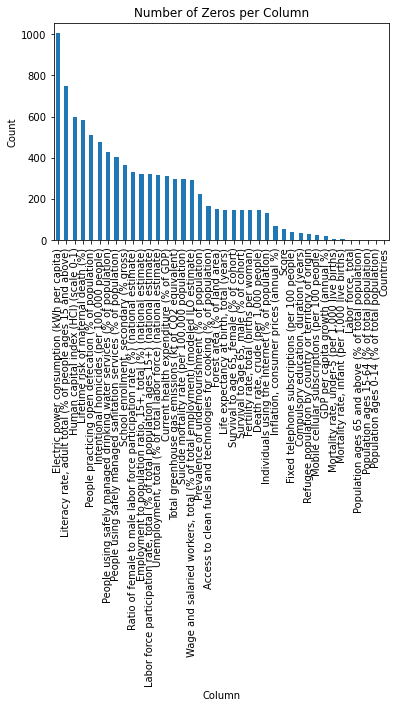

In [146]:
# count number of zeros per column
zeros_per_column = (data == 0).sum()

# plot a bar graph
zeros_per_column=zeros_per_column.sort_values(ascending=False)
zeros_per_column.plot(kind='bar')
plt.title('Number of Zeros per Column')
plt.xlabel('Column')
plt.ylabel('Count')
plt.show()

Observations:

2021 has a lot of missing values (not interesting to study). We choose to drop it. We also drop the 8 columns with the most missing values)

In [147]:

data=data.drop(columns=["Electric power consumption (kWh per capita)",
                        "Literacy rate, adult total (% of people ages 15 and above)",
                        "Human capital index (HCI) (scale 0-1)",
                        "Lifetime risk of maternal death (%)",
                        "People practicing open defecation (% of population)",
                        "Intentional homicides (per 100,000 people)",
                        "People using safely managed drinking water services (% of population)",
                        "People using safely managed sanitation services (% of population)",
                        ])
data2021=data[-145:]
data=data[:-145]

In [148]:
data.corr()

,Access to clean fuels and technologies for cooking (% of population),"Compulsory education, duration (years)",Current health expenditure (% of GDP),"Death rate, crude (per 1,000 people)","Employment to population ratio, 15+, total (%) (national estimate)","Fertility rate, total (births per woman)",Fixed telephone subscriptions (per 100 people),Forest area (% of land area),GDP per capita growth (annual %),Individuals using the Internet (% of population),...,Ratio of female to male labor force participation rate (%) (national estimate),Refugee population by country or territory of origin,"School enrollment, secondary (% gross)","Suicide mortality rate (per 100,000 population)","Survival to age 65, female (% of cohort)","Survival to age 65, male (% of cohort)",Total greenhouse gas emissions (kt of CO2 equivalent),"Unemployment, total (% of total labor force) (national estimate)","Wage and salaried workers, total (% of total employment) (modeled ILO estimate)",Score
Access to clean fuels and technologies for cooking (% of population),1.000000,0.998626,0.858991,0.997186,0.995677,0.994395,0.995499,0.995624,0.096052,0.998806,...,0.996891,0.897121,0.996953,0.855559,0.998795,0.998741,0.796649,0.992964,0.860103,-0.181565
"Compulsory education, duration (years)",0.998626,1.000000,0.861104,0.998301,0.995873,0.997286,0.994474,0.996917,0.099895,0.998077,...,0.996834,0.900526,0.996591,0.857552,0.999565,0.999467,0.797611,0.992482,0.861404,-0.203196
Current health expenditure (% of GDP),0.858991,0.861104,1.000000,0.844469,0.886065,0.867273,0.871849,0.860756,0.582598,0.845775,...,0.873323,0.772981,0.877668,0.995353,0.863958,0.866396,0.925420,0.856817,0.998649,-0.172880
"Death rate, crude (per 1,000 people)",0.997186,0.998301,0.844469,1.000000,0.993004,0.996630,0.992747,0.996597,0.069133,0.997780,...,0.995234,0.901289,0.994518,0.842570,0.998451,0.998095,0.781418,0.991945,0.844194,-0.215240
"Employment to population ratio, 15+, total (%) (national estimate)",0.995677,0.995873,0.886065,0.993004,1.000000,0.993234,0.995025,0.993955,0.155601,0.993870,...,0.998993,0.895747,0.996843,0.882677,0.996275,0.996450,0.822645,0.992812,0.886673,-0.182061
"Fertility rate, total (births per woman)",0.994395,0.997286,0.867273,0.996630,0.993234,1.000000,0.989637,0.995179,0.115510,0.993627,...,0.993363,0.905241,0.993181,0.863918,0.997699,0.997601,0.801129,0.988988,0.866158,-0.240061
Fixed telephone subscriptions (per 100 people),0.995499,0.994474,0.871849,0.992747,0.995025,0.989637,1.000000,0.991375,0.129363,0.994622,...,0.995877,0.889376,0.996052,0.868543,0.994932,0.995182,0.807785,0.991234,0.873014,-0.161072
Forest area (% of land area),0.995624,0.996917,0.860756,0.996597,0.993955,0.995179,0.991375,1.000000,0.103155,0.995334,...,0.995193,0.896417,0.994297,0.857575,0.997232,0.997120,0.796866,0.990102,0.860367,-0.210100
GDP per capita growth (annual %),0.096052,0.099895,0.582598,0.069133,0.155601,0.115510,0.129363,0.103155,1.000000,0.069981,...,0.128004,0.077336,0.137088,0.581934,0.104934,0.109584,0.542304,0.103644,0.582859,-0.025186
Individuals using the Internet (% of population),0.998806,0.998077,0.845775,0.997780,0.993870,0.993627,0.994622,0.995334,0.069981,1.000000,...,0.995984,0.896631,0.995833,0.842360,0.998325,0.998239,0.784016,0.991834,0.846855,-0.180617


In [38]:
X=data.drop(columns=["Score","Countries"],axis=1)
y=data["Score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Create and fit an ElasticNet regression model
enet = ElasticNet()
enet.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = enet.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)


Mean Squared Error (MSE): 2.613956945366449


C:\Users\USER\OneDrive\Bureau\Yassine\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.460227945720817, tolerance: 0.1788802103065737
  model = cd_fast.enet_coordinate_descent(


In [39]:
# Define the hyperparameter grid elastic net
param_grid = {
    'alpha': [0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
    'max_iter': [100, 500, 1000, 10000]
}

# Perform grid search with cross-validation
elasticnet_cv = GridSearchCV(enet, param_grid, cv=5, scoring='neg_mean_squared_error')
elasticnet_cv.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_params = elasticnet_cv.best_params_
print("Best Hyperparameters:", best_params)

# Predict on the test set using the best model
y_pred = elasticnet_cv.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print("MSE =",mse)


C:\Users\USER\OneDrive\Bureau\Yassine\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 385.3828097473749, tolerance: 0.1406073585378061
  model = cd_fast.enet_coordinate_descent(
C:\Users\USER\OneDrive\Bureau\Yassine\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 388.696029158578, tolerance: 0.1389499574059618
  model = cd_fast.enet_coordinate_descent(
C:\Users\USER\OneDrive\Bureau\Yassine\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 386.71658041419477, tolerance: 0.14956629666222793
  model = cd_fast.enet_coordinate_descent(
C:\Users\USER\OneDrive\Bureau\Yassine\A

C:\Users\USER\OneDrive\Bureau\Yassine\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 302.5392763702588, tolerance: 0.1406073585378061
  model = cd_fast.enet_coordinate_descent(
C:\Users\USER\OneDrive\Bureau\Yassine\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 302.98452197716705, tolerance: 0.1389499574059618
  model = cd_fast.enet_coordinate_descent(
C:\Users\USER\OneDrive\Bureau\Yassine\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 303.0626931383142, tolerance: 0.14956629666222793
  model = cd_fast.enet_coordinate_descent(
C:\Users\USER\OneDrive\Bureau\Yassine\

C:\Users\USER\OneDrive\Bureau\Yassine\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 267.9480536371093, tolerance: 0.1406073585378061
  model = cd_fast.enet_coordinate_descent(
C:\Users\USER\OneDrive\Bureau\Yassine\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 261.478386108365, tolerance: 0.1389499574059618
  model = cd_fast.enet_coordinate_descent(
C:\Users\USER\OneDrive\Bureau\Yassine\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 275.07656451783197, tolerance: 0.14956629666222793
  model = cd_fast.enet_coordinate_descent(
C:\Users\USER\OneDrive\Bureau\Yassine\A

C:\Users\USER\OneDrive\Bureau\Yassine\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 168.50327764546222, tolerance: 0.1406073585378061
  model = cd_fast.enet_coordinate_descent(
C:\Users\USER\OneDrive\Bureau\Yassine\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 171.2824824062904, tolerance: 0.1389499574059618
  model = cd_fast.enet_coordinate_descent(
C:\Users\USER\OneDrive\Bureau\Yassine\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 267.9783139191881, tolerance: 0.14956629666222793
  model = cd_fast.enet_coordinate_descent(
C:\Users\USER\OneDrive\Bureau\Yassine\

C:\Users\USER\OneDrive\Bureau\Yassine\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.940566178959898, tolerance: 0.1406073585378061
  model = cd_fast.enet_coordinate_descent(
C:\Users\USER\OneDrive\Bureau\Yassine\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.896709466647735, tolerance: 0.1389499574059618
  model = cd_fast.enet_coordinate_descent(
C:\Users\USER\OneDrive\Bureau\Yassine\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.774080955152556, tolerance: 0.14956629666222793
  model = cd_fast.enet_coordinate_descent(
C:\Users\USER\OneDrive\Bureau\Yassine\

C:\Users\USER\OneDrive\Bureau\Yassine\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6988542124855712, tolerance: 0.1406073585378061
  model = cd_fast.enet_coordinate_descent(
C:\Users\USER\OneDrive\Bureau\Yassine\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5544665393674677, tolerance: 0.1389499574059618
  model = cd_fast.enet_coordinate_descent(
C:\Users\USER\OneDrive\Bureau\Yassine\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.44005870404942, tolerance: 0.14956629666222793
  model = cd_fast.enet_coordinate_descent(
C:\Users\USER\OneDrive\Bureau\Yassine\

C:\Users\USER\OneDrive\Bureau\Yassine\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.818668716477077, tolerance: 0.1406073585378061
  model = cd_fast.enet_coordinate_descent(
C:\Users\USER\OneDrive\Bureau\Yassine\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.872453718634006, tolerance: 0.1389499574059618
  model = cd_fast.enet_coordinate_descent(
C:\Users\USER\OneDrive\Bureau\Yassine\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56.448129165249384, tolerance: 0.14956629666222793
  model = cd_fast.enet_coordinate_descent(
C:\Users\USER\OneDrive\Bureau\Yassine

Best Hyperparameters: {'alpha': 0.1, 'l1_ratio': 0.5, 'max_iter': 10000}
MSE = 1.7135156218396848


C:\Users\USER\OneDrive\Bureau\Yassine\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.372957496252866, tolerance: 0.1788802103065737
  model = cd_fast.enet_coordinate_descent(


In [40]:
# Get the best hyperparameters
best_params = elasticnet_cv.best_params_
print("Best Hyperparameters for ElasticNet: ", best_params)

# Predict on the test set using the best model
y_pred = elasticnet_cv.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print("MSE ElasticNet =",mse)


Best Hyperparameters for ElasticNet:  {'alpha': 0.1, 'l1_ratio': 0.5, 'max_iter': 10000}
MSE ElasticNet = 1.7135156218396848


In [41]:
linear_regression = LinearRegression()

# Train the model
linear_regression.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = linear_regression.predict(X_test_scaled)

# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Print the MSE
print("Mean Squared Error (MSE) For Linear Regression:", mse)

Mean Squared Error (MSE) For Linear Regression: 1.905918414231191


In [42]:


#Ridge regression 
ridge_model = Ridge(alpha=1.0)  
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)

#Lasso regression
lasso_model = Lasso(alpha=1.0)  
lasso_model.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)

# Print the MSE for Ridge and Lasso models
print("Mean Squared Error (MSE) - Ridge Regression:", mse_ridge)
print("Mean Squared Error (MSE) - Lasso Regression:", mse_lasso)

Mean Squared Error (MSE) - Ridge Regression: 2.022320570134365
Mean Squared Error (MSE) - Lasso Regression: 2.7746346536564364


In [43]:
listofalphas=[]
i=0.001
while i<=10:
    listofalphas.append(i)
    i+=0.001
    
ridge_model_cv = RidgeCV(alphas=listofalphas) 
ridge_model_cv.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model_cv.predict(X_test_scaled)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
print("Best alpha for Ridge regression:", ridge_model_cv.alpha_)
print("Mean Squared Error (MSE) - Ridge Regression:", mse_ridge)

# Lasso
lasso_model_cv = LassoCV(alphas=[0.001,0.01,0.1,1,10])  
lasso_model_cv.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model_cv.predict(X_test_scaled)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print("Best alpha for Lasso regression:", lasso_model_cv.alpha_)
print("Mean Squared Error (MSE) - Lasso Regression:", mse_lasso)

Best alpha for Ridge regression: 0.001
Mean Squared Error (MSE) - Ridge Regression: 1.90622515450606
Best alpha for Lasso regression: 0.1
Mean Squared Error (MSE) - Lasso Regression: 1.8894238517431432


C:\Users\USER\OneDrive\Bureau\Yassine\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114.69376629297659, tolerance: 0.1406073585378061
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\USER\OneDrive\Bureau\Yassine\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 286.75945543459056, tolerance: 0.1406073585378061
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\USER\OneDrive\Bureau\Yassine\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 322.5199304082384, tolerance: 0.1406073585378061
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\USER\OneDrive\

To do: 
- Use some values from data we have in 2021 to predict the score of some countries with our model
- Correlation matrix
- Impute values with PCA?


In [44]:
Country = "Denmark"
score=h2021.loc[h2021["Country name"] == Country].iloc[0, 0]
print("Country =", Country)
print("Score =",score)

Country = Denmark
Score = 7.62


In [45]:
X=data2021.loc[data2021["Countries"] == Country].drop(columns=["Countries","Score"])
y=data2021.loc[data2021["Countries"] == Country].Score.to_list()
X=scaler.fit_transform(X)

#Testing our models
models=[linear_regression,
lasso_model_cv,
ridge_model_cv,
elasticnet_cv]
modelnames=["linear_regression",
"lasso_model_cv",
"ridge_model_cv",
"elasticnet_cv"]

print("y_true =",y)

for i in range(len(models)):
  print("Model =",modelnames[i])
  y_pred=models[i].predict(X)
  print("ypred =",y_pred)
  MSE=mean_squared_error(y, y_pred)
  print("MSE =",MSE)


y_true = [7.62]
Model = linear_regression
ypred = [6.03697254]
MSE = 2.505975926442942
Model = lasso_model_cv
ypred = [5.49471012]
MSE = 4.516857084617672
Model = ridge_model_cv
ypred = [6.03601449]
MSE = 2.50901009595889
Model = elasticnet_cv
ypred = [5.50042638]
MSE = 4.492592336866854


In [46]:
data.dtypes

Countries                                                                                      object
Access to clean fuels and technologies for cooking (% of population)                          float64
Compulsory education, duration (years)                                                          int64
Current health expenditure (% of GDP)                                                         float64
Death rate, crude (per 1,000 people)                                                          float64
Employment to population ratio, 15+, total (%) (national estimate)                            float64
Fertility rate, total (births per woman)                                                      float64
Fixed telephone subscriptions (per 100 people)                                                float64
Forest area (% of land area)                                                                  float64
GDP per capita growth (annual %)                                                  

In [47]:
data.corr()

,Access to clean fuels and technologies for cooking (% of population),"Compulsory education, duration (years)",Current health expenditure (% of GDP),"Death rate, crude (per 1,000 people)","Employment to population ratio, 15+, total (%) (national estimate)","Fertility rate, total (births per woman)",Fixed telephone subscriptions (per 100 people),Forest area (% of land area),GDP per capita growth (annual %),Individuals using the Internet (% of population),...,Ratio of female to male labor force participation rate (%) (national estimate),Refugee population by country or territory of origin,"School enrollment, secondary (% gross)","Suicide mortality rate (per 100,000 population)","Survival to age 65, female (% of cohort)","Survival to age 65, male (% of cohort)",Total greenhouse gas emissions (kt of CO2 equivalent),"Unemployment, total (% of total labor force) (national estimate)","Wage and salaried workers, total (% of total employment) (modeled ILO estimate)",Score
Access to clean fuels and technologies for cooking (% of population),1.000000,0.998626,0.858991,0.997186,0.995677,0.994395,0.995499,0.995624,0.096052,0.998806,...,0.996891,0.897121,0.996953,0.855559,0.998795,0.998741,0.796649,0.992964,0.860103,-0.181565
"Compulsory education, duration (years)",0.998626,1.000000,0.861104,0.998301,0.995873,0.997286,0.994474,0.996917,0.099895,0.998077,...,0.996834,0.900526,0.996591,0.857552,0.999565,0.999467,0.797611,0.992482,0.861404,-0.203196
Current health expenditure (% of GDP),0.858991,0.861104,1.000000,0.844469,0.886065,0.867273,0.871849,0.860756,0.582598,0.845775,...,0.873323,0.772981,0.877668,0.995353,0.863958,0.866396,0.925420,0.856817,0.998649,-0.172880
"Death rate, crude (per 1,000 people)",0.997186,0.998301,0.844469,1.000000,0.993004,0.996630,0.992747,0.996597,0.069133,0.997780,...,0.995234,0.901289,0.994518,0.842570,0.998451,0.998095,0.781418,0.991945,0.844194,-0.215240
"Employment to population ratio, 15+, total (%) (national estimate)",0.995677,0.995873,0.886065,0.993004,1.000000,0.993234,0.995025,0.993955,0.155601,0.993870,...,0.998993,0.895747,0.996843,0.882677,0.996275,0.996450,0.822645,0.992812,0.886673,-0.182061
"Fertility rate, total (births per woman)",0.994395,0.997286,0.867273,0.996630,0.993234,1.000000,0.989637,0.995179,0.115510,0.993627,...,0.993363,0.905241,0.993181,0.863918,0.997699,0.997601,0.801129,0.988988,0.866158,-0.240061
Fixed telephone subscriptions (per 100 people),0.995499,0.994474,0.871849,0.992747,0.995025,0.989637,1.000000,0.991375,0.129363,0.994622,...,0.995877,0.889376,0.996052,0.868543,0.994932,0.995182,0.807785,0.991234,0.873014,-0.161072
Forest area (% of land area),0.995624,0.996917,0.860756,0.996597,0.993955,0.995179,0.991375,1.000000,0.103155,0.995334,...,0.995193,0.896417,0.994297,0.857575,0.997232,0.997120,0.796866,0.990102,0.860367,-0.210100
GDP per capita growth (annual %),0.096052,0.099895,0.582598,0.069133,0.155601,0.115510,0.129363,0.103155,1.000000,0.069981,...,0.128004,0.077336,0.137088,0.581934,0.104934,0.109584,0.542304,0.103644,0.582859,-0.025186
Individuals using the Internet (% of population),0.998806,0.998077,0.845775,0.997780,0.993870,0.993627,0.994622,0.995334,0.069981,1.000000,...,0.995984,0.896631,0.995833,0.842360,0.998325,0.998239,0.784016,0.991834,0.846855,-0.180617


In [48]:
import seaborn as sns
corr_matrix = data.corr()
corr_matrix
#sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
#plt.title("Correlation Matrix")
#plt.show()
#corr_with_score = corr_matrix["Score"].abs().sort_values(ascending=False)
#importance = list(corr_with_score.index)
#print("Ranking of columns based on importance in predicting Score:")
#for i, feature in enumerate(importance):
#   print(f"{i+1}. {feature}")

,Access to clean fuels and technologies for cooking (% of population),"Compulsory education, duration (years)",Current health expenditure (% of GDP),"Death rate, crude (per 1,000 people)","Employment to population ratio, 15+, total (%) (national estimate)","Fertility rate, total (births per woman)",Fixed telephone subscriptions (per 100 people),Forest area (% of land area),GDP per capita growth (annual %),Individuals using the Internet (% of population),...,Ratio of female to male labor force participation rate (%) (national estimate),Refugee population by country or territory of origin,"School enrollment, secondary (% gross)","Suicide mortality rate (per 100,000 population)","Survival to age 65, female (% of cohort)","Survival to age 65, male (% of cohort)",Total greenhouse gas emissions (kt of CO2 equivalent),"Unemployment, total (% of total labor force) (national estimate)","Wage and salaried workers, total (% of total employment) (modeled ILO estimate)",Score
Access to clean fuels and technologies for cooking (% of population),1.000000,0.998626,0.858991,0.997186,0.995677,0.994395,0.995499,0.995624,0.096052,0.998806,...,0.996891,0.897121,0.996953,0.855559,0.998795,0.998741,0.796649,0.992964,0.860103,-0.181565
"Compulsory education, duration (years)",0.998626,1.000000,0.861104,0.998301,0.995873,0.997286,0.994474,0.996917,0.099895,0.998077,...,0.996834,0.900526,0.996591,0.857552,0.999565,0.999467,0.797611,0.992482,0.861404,-0.203196
Current health expenditure (% of GDP),0.858991,0.861104,1.000000,0.844469,0.886065,0.867273,0.871849,0.860756,0.582598,0.845775,...,0.873323,0.772981,0.877668,0.995353,0.863958,0.866396,0.925420,0.856817,0.998649,-0.172880
"Death rate, crude (per 1,000 people)",0.997186,0.998301,0.844469,1.000000,0.993004,0.996630,0.992747,0.996597,0.069133,0.997780,...,0.995234,0.901289,0.994518,0.842570,0.998451,0.998095,0.781418,0.991945,0.844194,-0.215240
"Employment to population ratio, 15+, total (%) (national estimate)",0.995677,0.995873,0.886065,0.993004,1.000000,0.993234,0.995025,0.993955,0.155601,0.993870,...,0.998993,0.895747,0.996843,0.882677,0.996275,0.996450,0.822645,0.992812,0.886673,-0.182061
"Fertility rate, total (births per woman)",0.994395,0.997286,0.867273,0.996630,0.993234,1.000000,0.989637,0.995179,0.115510,0.993627,...,0.993363,0.905241,0.993181,0.863918,0.997699,0.997601,0.801129,0.988988,0.866158,-0.240061
Fixed telephone subscriptions (per 100 people),0.995499,0.994474,0.871849,0.992747,0.995025,0.989637,1.000000,0.991375,0.129363,0.994622,...,0.995877,0.889376,0.996052,0.868543,0.994932,0.995182,0.807785,0.991234,0.873014,-0.161072
Forest area (% of land area),0.995624,0.996917,0.860756,0.996597,0.993955,0.995179,0.991375,1.000000,0.103155,0.995334,...,0.995193,0.896417,0.994297,0.857575,0.997232,0.997120,0.796866,0.990102,0.860367,-0.210100
GDP per capita growth (annual %),0.096052,0.099895,0.582598,0.069133,0.155601,0.115510,0.129363,0.103155,1.000000,0.069981,...,0.128004,0.077336,0.137088,0.581934,0.104934,0.109584,0.542304,0.103644,0.582859,-0.025186
Individuals using the Internet (% of population),0.998806,0.998077,0.845775,0.997780,0.993870,0.993627,0.994622,0.995334,0.069981,1.000000,...,0.995984,0.896631,0.995833,0.842360,0.998325,0.998239,0.784016,0.991834,0.846855,-0.180617


In [49]:
# The method works only for numerical variables so we discard the "Countries" column
data_without_countries = data.drop('Countries', axis=1)

# We impute missing values with a K-nearest neighbors type method
imputer = KNNImputer(missing_values = 0, n_neighbors = 5, weights = 'distance')

imputed_data = imputer.fit_transform(data_without_countries)

# We merge back the "Countries" column with the newly formed data to get the new dataframe without any missing values
imputed_data_with_countries = np.column_stack((data['Countries'].to_numpy(),imputed_data))
merged_data = pd.DataFrame(imputed_data_with_countries, columns=data.columns)

merged_data

,Countries,Access to clean fuels and technologies for cooking (% of population),"Compulsory education, duration (years)",Current health expenditure (% of GDP),"Death rate, crude (per 1,000 people)","Employment to population ratio, 15+, total (%) (national estimate)","Fertility rate, total (births per woman)",Fixed telephone subscriptions (per 100 people),Forest area (% of land area),GDP per capita growth (annual %),...,Ratio of female to male labor force participation rate (%) (national estimate),Refugee population by country or territory of origin,"School enrollment, secondary (% gross)","Suicide mortality rate (per 100,000 population)","Survival to age 65, female (% of cohort)","Survival to age 65, male (% of cohort)",Total greenhouse gas emissions (kt of CO2 equivalent),"Unemployment, total (% of total labor force) (national estimate)","Wage and salaried workers, total (% of total employment) (modeled ILO estimate)",Score
0,Afghanistan,27.4,9.0,10.105348,7.331,42.169843,5.405,0.325892,1.852782,-1.666416,...,31.98708,2666294.0,51.669949,4.0,65.49806,56.993402,27090.000153,9.612766,15.79,3.575
1,Albania,76.2,9.0,4.896312,7.947,45.959999,1.613,7.86538,28.802464,2.516827,...,73.328137,10404.0,97.388481,4.8,91.512091,84.678267,9220.000267,17.190001,41.189999,4.959
2,Algeria,99.5,10.0,6.978489,4.437,37.029999,3.041,8.263357,0.821248,1.646657,...,24.390242,3470.0,73.706194,2.7,86.476312,82.114127,263140.014648,11.21,68.650002,5.605
3,Argentina,99.7,14.0,10.229339,7.543,56.160765,2.301,23.286658,10.632187,1.629664,...,75.264063,186.0,106.946472,8.3,87.294176,77.188329,370000.0,8.763238,75.959999,6.574
4,Armenia,97.8,12.0,10.117634,9.607,50.919998,1.602,19.153997,11.574289,3.606369,...,74.851452,11211.0,86.00589,6.2,87.99091,70.401364,9159.999847,18.26,57.200001,4.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
863,Venezuela,97.0,17.0,3.842713,7.575,47.372496,2.23,18.431374,52.413015,-1.348518,...,65.437787,171112.0,47.064509,6.331648,82.270457,66.765276,197049.614578,7.53,51.440653,5.0532
864,Vietnam,65.3,10.0,4.45136,6.169,71.739998,1.955,3.316936,46.719002,1.937355,...,85.974915,316728.0,103.636578,7.4344,88.300898,74.778522,319855.265401,2.1,38.560586,5.3535
865,Yemen,61.5,9.0,5.089111,6.509,54.454838,3.886,3.840906,1.039832,2.099138,...,82.36568,32433.0,56.779363,7.754443,71.396379,57.704862,34810.612505,3.250455,20.810912,3.5274
866,Zambia,10.4,7.0,9.406487,6.602,57.200001,4.379,0.37957,60.283337,-5.595733,...,80.515847,252.0,65.954752,6.123468,64.511353,51.7564,46075.553918,6.03,49.131811,3.7594


In [50]:
kkcols_to_convert = merged_data.columns.difference(['Countries'])  # Exclude 'countries' column
merged_data[cols_to_convert] = merged_data[cols_to_convert].apply(pd.to_numeric, errors='coerce')

merged_data.dtypes

merged_data.corr()

,Access to clean fuels and technologies for cooking (% of population),"Compulsory education, duration (years)",Current health expenditure (% of GDP),"Death rate, crude (per 1,000 people)","Employment to population ratio, 15+, total (%) (national estimate)","Fertility rate, total (births per woman)",Fixed telephone subscriptions (per 100 people),Forest area (% of land area),GDP per capita growth (annual %),Individuals using the Internet (% of population),...,Ratio of female to male labor force participation rate (%) (national estimate),Refugee population by country or territory of origin,"School enrollment, secondary (% gross)","Suicide mortality rate (per 100,000 population)","Survival to age 65, female (% of cohort)","Survival to age 65, male (% of cohort)",Total greenhouse gas emissions (kt of CO2 equivalent),"Unemployment, total (% of total labor force) (national estimate)","Wage and salaried workers, total (% of total employment) (modeled ILO estimate)",Score
Access to clean fuels and technologies for cooking (% of population),1.000000,0.998655,0.998304,0.997314,0.995777,0.994439,0.995708,0.995628,0.095877,0.999055,...,0.997116,0.897049,0.998144,0.995027,0.998936,0.998886,0.931733,0.992444,0.999390,0.022977
"Compulsory education, duration (years)",0.998655,1.000000,0.999059,0.998458,0.997457,0.997751,0.994308,0.997104,0.099862,0.998251,...,0.998440,0.900848,0.998351,0.995649,0.999685,0.999582,0.931168,0.993126,0.999050,-0.004925
Current health expenditure (% of GDP),0.998304,0.999059,1.000000,0.998258,0.997047,0.997093,0.995025,0.996574,0.101661,0.998047,...,0.998403,0.903440,0.998220,0.996180,0.999250,0.999216,0.931643,0.993643,0.998989,-0.000401
"Death rate, crude (per 1,000 people)",0.997314,0.998458,0.998258,1.000000,0.994715,0.996630,0.992832,0.996618,0.069076,0.997991,...,0.997121,0.901298,0.996158,0.996409,0.998451,0.998095,0.930051,0.993043,0.997951,-0.017067
"Employment to population ratio, 15+, total (%) (national estimate)",0.995777,0.997457,0.997047,0.994715,1.000000,0.997300,0.993929,0.995474,0.154787,0.994143,...,0.999167,0.898479,0.998428,0.994038,0.997864,0.998011,0.929619,0.991731,0.996858,-0.010744
"Fertility rate, total (births per woman)",0.994439,0.997751,0.997093,0.996630,0.997300,1.000000,0.989847,0.995171,0.115447,0.993990,...,0.997550,0.905243,0.996048,0.993905,0.997699,0.997601,0.927387,0.992185,0.995972,-0.046890
Fixed telephone subscriptions (per 100 people),0.995708,0.994308,0.995025,0.992832,0.993929,0.989847,1.000000,0.991653,0.129421,0.994551,...,0.994875,0.889357,0.995744,0.991812,0.994955,0.995209,0.927586,0.989369,0.995769,0.044451
Forest area (% of land area),0.995628,0.997104,0.996574,0.996618,0.995474,0.995171,0.991653,1.000000,0.103108,0.995561,...,0.996698,0.896396,0.996235,0.993618,0.997281,0.997175,0.928824,0.990607,0.996302,-0.006332
GDP per capita growth (annual %),0.095877,0.099862,0.101661,0.069076,0.154787,0.115447,0.129421,0.103108,1.000000,0.069683,...,0.127048,0.077214,0.136319,0.102600,0.104877,0.109525,0.096922,0.102368,0.101732,-0.000631
Individuals using the Internet (% of population),0.999055,0.998251,0.998047,0.997991,0.994143,0.993990,0.994551,0.995561,0.069683,1.000000,...,0.996370,0.896519,0.996893,0.994762,0.998550,0.998445,0.930942,0.991263,0.998972,0.022752


Since we have a relatively small dataset, we can use a kernel method too.